<div align = "center"><img src = "wineillustration.png" rel="stylesheet"" width = "300"></div>

# Calidad de vino tinto

En este ejercicio se aplicará la Random Forests en un dataset con 1599 registros.

URL: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Objetivos

El trabajo consiste en predecir la calidad del vino tinto.

### 1. Generación del conjunto de datos

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from pprint import pprint
from scipy import stats
import seaborn as sns
import pandas as pd
%matplotlib inline
import numpy as np
import pydotplus
import graphviz
import warnings
import itertools
#Comparar la distribución de las clases en y_train antes y después del reequilibrio para ver cómo se han ajustado:
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from keras.regularizers import l1_l2
from keras.utils import to_categorical
import shap
import joblib


In [9]:
# Leer el dataset winequality
df = pd.read_csv('winequality-red.csv')
warnings.filterwarnings('ignore')

In [10]:
# Mostrar información básica sobre el conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   object 
 11  quality               1599 non-null   int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 150.0+ KB


In [11]:
print(df.loc[1359, 'alcohol'])
print(df.loc[1362, 'alcohol'])
print(df.loc[1439, 'alcohol'])
print(df.loc[1441, 'alcohol'])
print(df.loc[1475, 'alcohol'])
print(df.loc[1514, 'alcohol'])
# Filtrar las filas donde la columna 'density' es mayor que 2
incorrect_density = df.loc[df['density'] >= 2].index
# Imprimir el número de filas con densidades incorrectas
print(f"# densidad incorrecta (>= 2) es: {len(incorrect_density)}")

100.333.333.333.333
100.333.333.333.333
110.666.666.666.667
956.666.666.666.667
135.666.666.666.667
923.333.333.333.333
# densidad incorrecta (>= 2) es: 65


In [12]:
incorrect_alcohol = [1359, 1362, 1439, 1441, 1475, 1514]
rows_to_drop = incorrect_density.union(incorrect_alcohol)
df = df.drop(rows_to_drop)

In [13]:
# Selecciona las variables basadas en su relevancia para el proceso de fermentación.
df['alcohol'] = df['alcohol'].astype(float)
df['residual sugar'] = df['residual sugar'].astype(float)
df['density'] = df['density'].astype(float)
df['pH'] = df['pH'].astype(float)
df['quality'] = df['quality'].astype(int)
# Selecciona solo las columnas relevantes para el proceso de fermentación
df = df[['alcohol', 'residual sugar', 'density', 'pH', 'quality']]

In [14]:
# Comprobación de datos, se comprueban que no falten datos en el DataSet
df.isnull().sum()

alcohol           0
residual sugar    0
density           0
pH                0
quality           0
dtype: int64

In [15]:
# Calcula los valores absolutos de los z-scores de cada valor en el DataFrame
z = np.abs(stats.zscore(df))
z.head(10)

,alcohol,residual sugar,density,pH,quality
0,0.974294,0.469374,0.732730,1.271213,0.784492
1,0.597104,0.121577,0.139068,0.770175,0.784492
2,0.597104,0.131688,0.257800,0.375067,0.784492
3,0.597104,0.469374,0.851462,1.033580,0.452561
4,0.974294,0.469374,0.732730,1.271213,0.784492
5,0.974294,0.553796,0.732730,1.271213,0.784492
6,0.974294,0.722639,0.098397,0.111663,0.784492
7,0.408509,1.060325,1.166989,0.480998,1.689614
8,0.879996,0.384953,0.139068,0.283445,1.689614
9,0.062978,3.076333,0.732730,0.217593,0.784492


In [16]:
# Eliminación de valores atípicos basada en puntuación Z
threshold = 3
np.where(z > 3)

(array([   9,   11,   33,   45,   95,  142,  144,  151,  163,  164,  271,
         275,  340,  359,  374,  378,  391,  439,  463,  469,  470,  483,
         485,  506,  541,  547,  596,  599,  599,  635,  640,  761,  772,
         776,  777,  838,  850,  856,  862,  956,  957,  977,  982, 1010,
        1013, 1016, 1017, 1018, 1020, 1050, 1053, 1065, 1086, 1125, 1174,
        1183, 1208, 1208, 1209, 1209, 1215, 1238, 1239, 1255, 1260, 1311,
        1325, 1402, 1408, 1435, 1487, 1503, 1518], dtype=int64),
 array([1, 1, 1, 3, 3, 0, 0, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        4, 1, 0, 1, 1, 0, 1, 4, 3, 0, 4, 2, 2, 4, 1, 1, 1, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 4, 3, 3, 3, 4,
        1, 4, 4, 4, 1, 1, 1], dtype=int64))

In [17]:
df_o = df[(z < 3).all(axis = 1)]
print("Antiguo Shape: ", df.shape)
print("Nuevo Shape: ", df_o.shape)

Antiguo Shape:  (1528, 5)
Nuevo Shape:  (1458, 5)


### 2. Visualización del conjunto de datos

In [19]:
df_o.head(10)

,alcohol,residual sugar,density,pH,quality
0,9.4,1.9,0.9978,3.51,5
1,9.8,2.6,0.9968,3.20,5
2,9.8,2.3,0.9970,3.26,5
3,9.8,1.9,0.9980,3.16,6
4,9.4,1.9,0.9978,3.51,5
5,9.4,1.8,0.9978,3.51,5
6,9.4,1.6,0.9964,3.30,5
7,10.0,1.2,0.9946,3.39,7
8,9.5,2.0,0.9968,3.36,7
10,9.2,1.8,0.9959,3.28,5


In [20]:
# Mostrar información estadística sobre el conjunto de datos
df_o.describe()

,alcohol,residual sugar,density,pH,quality
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,10.386008,2.317936,0.996597,3.314143,5.640604
std,1.004771,0.743089,0.001580,0.144578,0.775250
min,8.500000,1.200000,0.991570,2.870000,4.000000
25%,9.500000,1.900000,0.995600,3.220000,5.000000
50%,10.100000,2.200000,0.996625,3.310000,6.000000
75%,11.000000,2.500000,0.997600,3.400000,6.000000
max,13.600000,6.000000,1.001000,3.750000,8.000000


In [21]:
df_o[df_o['quality'] == 8].describe()

,alcohol,residual sugar,density,pH,quality
count,15.000000,15.000000,15.000000,15.000000,15.0
mean,11.806667,2.413333,0.995581,3.224000,8.0
std,1.092485,0.947076,0.002011,0.168133,0.0
min,9.800000,1.400000,0.992350,2.880000,8.0
25%,11.150000,1.800000,0.994350,3.150000,8.0
50%,11.700000,2.200000,0.995160,3.220000,8.0
75%,12.750000,2.600000,0.997200,3.295000,8.0
max,13.400000,5.200000,0.998800,3.560000,8.0


In [22]:
df_o['quality'].value_counts()

5    635
6    583
7    177
4     48
8     15
Name: quality, dtype: int64

El análisis de la distribución de las clases en el conjunto de datos revela un significativo desbalance. 
Este desbalance es evidente, ya que algunas clases, como la 5 y la 6, tienen una representación mucho mayor en comparación con otras clases, como la 3 y la 8, que están considerablemente subrepresentadas. Esta disparidad en la cantidad de registros entre las diferentes clases puede afectar la eficacia de los modelos de aprendizaje automático, que pueden verse sesgados hacia las clases mayoritarias.

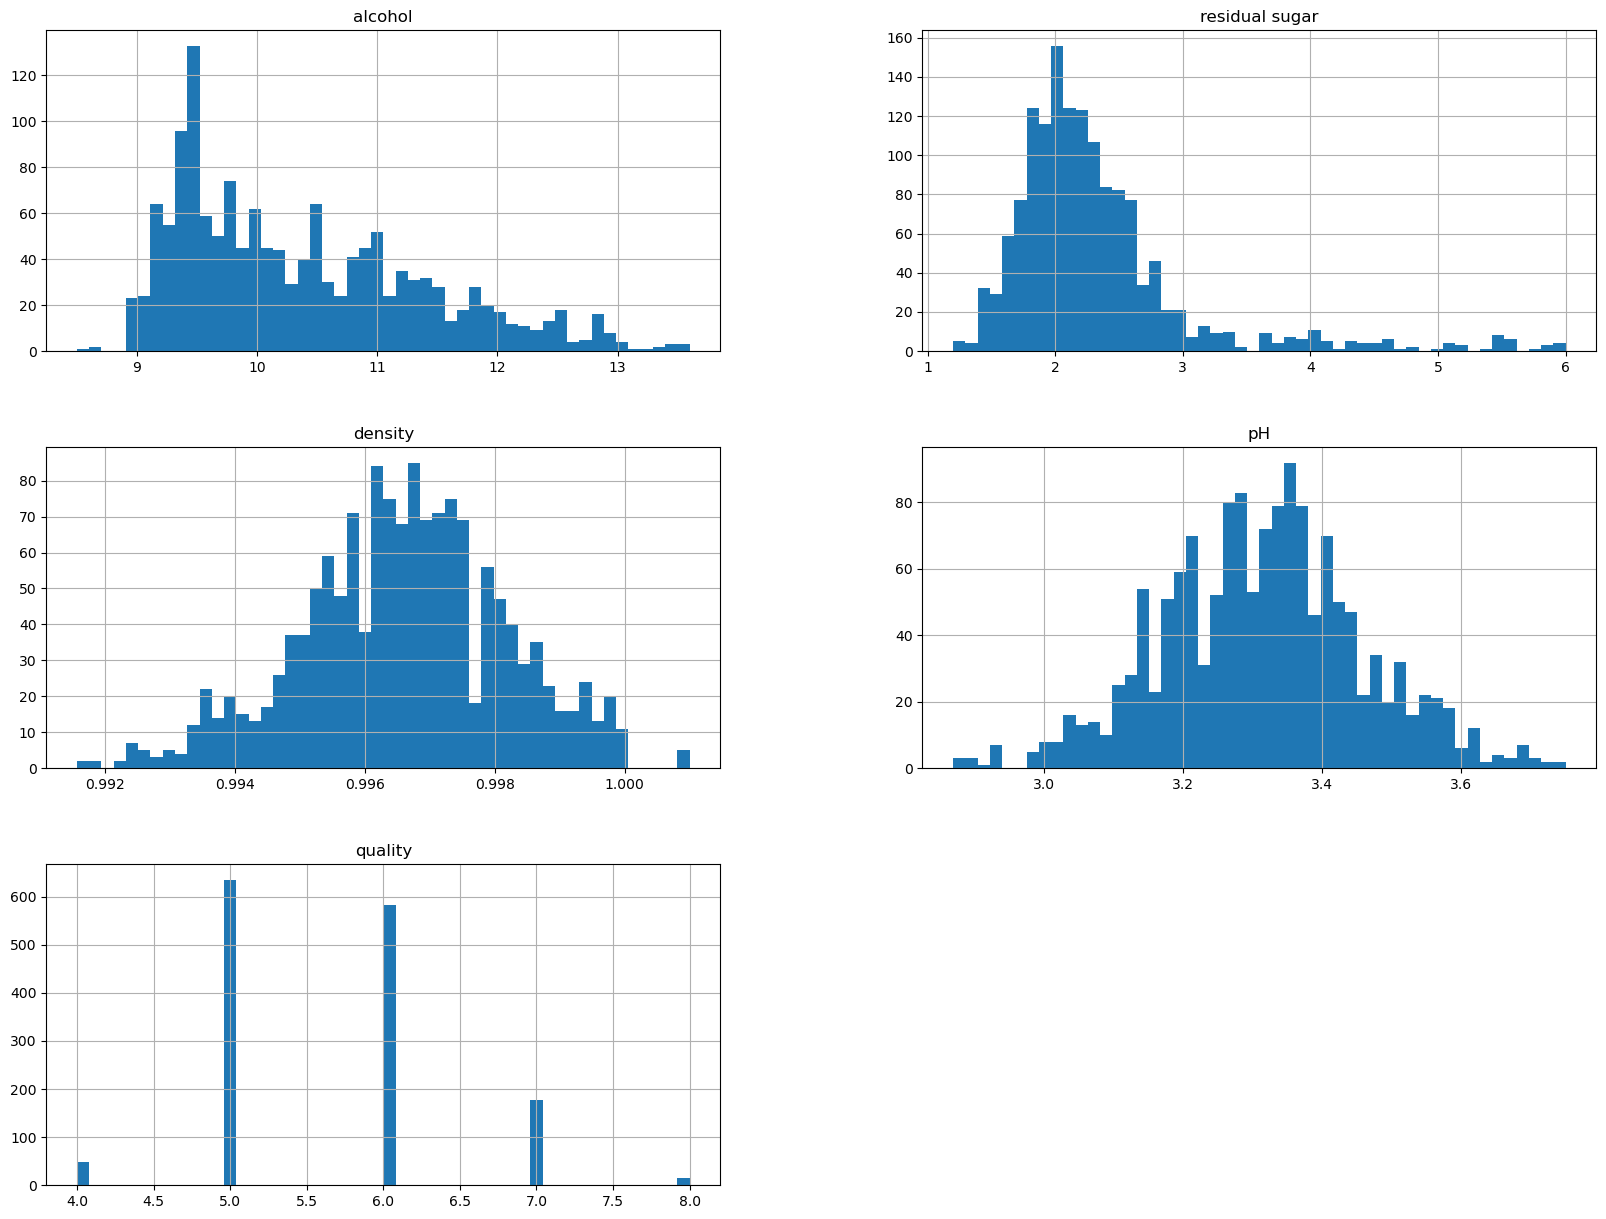

In [24]:
# Representar gráficamente la distribución de los atributos
df_o.hist(bins = 50, figsize = (20, 15))
plt.show()

In [25]:
print("Longitud del conjunto de datos:", len(df_o))
print("Número de características del conjunto de datos:", len(df_o.columns))

Longitud del conjunto de datos: 1458
Número de características del conjunto de datos: 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


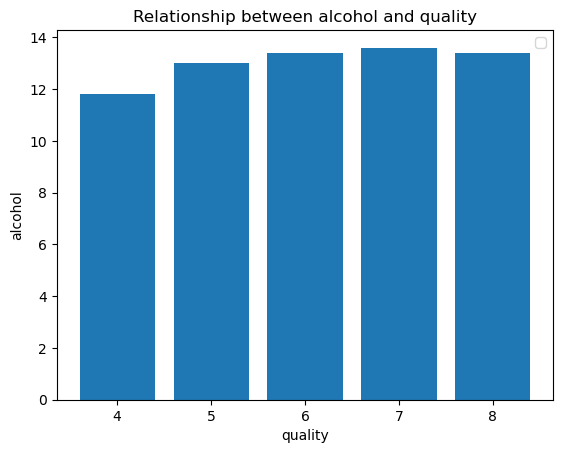

In [26]:
plt.bar(df_o['quality'], df_o['alcohol'])
plt.title('Relationship between alcohol and quality')
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.legend()
plt.show()

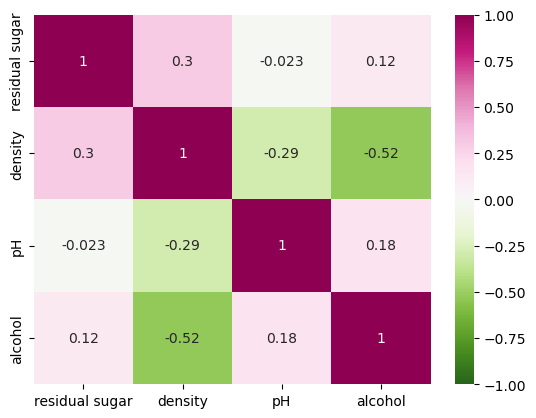

In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Hacemos una matriz de correlacion
df.corr()
nombre_columnas = ['residual sugar', 'density', 'pH', 'alcohol']
sns.heatmap(df_o[nombre_columnas].corr(), vmin=-1.0, vmax=1.0, annot=True, cmap="PiYG_r")
pass

### 4. Construcción del modelo

In [29]:
# División de los datos en conjuntos de entrenamiento y prueba.
X = df_o.drop(columns = 'quality', axis = 1)
y = df_o['quality']
X.head(10)

,alcohol,residual sugar,density,pH
0,9.4,1.9,0.9978,3.51
1,9.8,2.6,0.9968,3.20
2,9.8,2.3,0.9970,3.26
3,9.8,1.9,0.9980,3.16
4,9.4,1.9,0.9978,3.51
5,9.4,1.8,0.9978,3.51
6,9.4,1.6,0.9964,3.30
7,10.0,1.2,0.9946,3.39
8,9.5,2.0,0.9968,3.36
10,9.2,1.8,0.9959,3.28


In [30]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_scaled = Scaler_X.fit_transform(X)

In [31]:
# Guardar el scaler en un archivo
joblib.dump(Scaler_X, '../data/scalerETR.pkl')

['../data/scalerETR.pkl']

In [32]:
# Dividiendo los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

In [33]:
# Convertir y_train a un pandas Series para usar value_counts
y_train_series = pd.Series(y_train)

# Obtener las frecuencias de las clases en el conjunto de entrenamiento
class_counts = y_train_series.value_counts()

# Calcular el total de muestras en el conjunto de entrenamiento
total_samples = class_counts.sum()
print(total_samples)
# Calcular el número total de clases
num_classes = len(class_counts)
print(num_classes)
# Calcular el peso para cada clase
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

# Imprimir los pesos para verificar
print("Pesos de las clases:", class_weights)

1166
5
Pesos de las clases: {5: 0.4626984126984127, 6: 0.4993576017130621, 7: 1.653900709219858, 4: 5.552380952380952, 8: 19.433333333333334}


In [34]:
print(f"Tamaño original de X_train: {X_train.shape}")
print(f"Distribución original de clases en y_train: {Counter(y_train)}")

Tamaño original de X_train: (1166, 4)
Distribución original de clases en y_train: Counter({5: 504, 6: 467, 7: 141, 4: 42, 8: 12})


### 5. Evaluacion

In [106]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

def evaluate(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    # Mostrar las primeras 10 predicciones
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Primeras 10 predicciones:", y_pred[:10])
    # Calcular y mostrar la precisión (accuracy)
    print('Precisión (Accuracy) = {:0.3f}%.'.format(100 * accuracy))
    # Validación cruzada en el conjunto de entrenamiento
    cross_validation = cross_val_score(model,X_train,y_train,cv = 7)
    print('Puntuación media de la validación cruzada: {:.4f}%'.format(100 * np.mean(cross_validation)))
    # Calcular y mostrar las métricas de evaluación
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Puntuación de Recall: {:.4f}%".format(recall))
    print("Puntuación de Precisión: {:.4f}%".format(precision))
    print("Puntuación F1: {:.4f}%".format(f1))
    # Imprimir informe de clasificación
    print("Informe de Clasificación")
    print(classification_report(y_test, y_pred))
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix')
    # class_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
    # disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
    fig, ax = plt.subplots(figsize = (5, 5))
    disp = disp.plot(xticks_rotation = 'vertical', ax = ax, colorbar = False)
    plt.show()
    return accuracy


## El método de RandomizedSearchCV 
Permite la búsqueda aleatoria de hiperparámetros dentro de un rango especificado

In [26]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en el árbol.
max_depth = [int(x) for x in np.linspace(2, 14, num = 7)]
max_depth.append(None)
# Número mínimo de muestras necesarias para dividir un nodo
min_samples_split = [2, 5, 10, 50, 100]
# Número mínimo de muestras requeridas en cada nodo de hoja
min_samples_leaf = [1, 2, 4, 10, 30]
# Método de selección de muestras para entrenar cada árbol.
bootstrap = [True, False]
# Crea la cuadrícula aleatoria
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 30],
 'min_samples_split': [2, 5, 10, 50, 100],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## Entrenamiento Random Forest para Clasificación

In [27]:
# Crear un modelo RandomForestClassifier
rf_clf  = RandomForestClassifier()
# Configurar RandomizedSearchCV
rf_random_clf  = RandomizedSearchCV(estimator = rf_clf , param_distributions = random_grid, n_iter = 100, cv = 7, verbose = 2, random_state = 42, n_jobs = -1)
# Ajustar el modelo
rf_random_clf .fit(X_train, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


RandomizedSearchCV(cv=7, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 30],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              100],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Entrenamiento Random Forest para Regresión

In [28]:
# Utilice la cuadrícula aleatoria para buscar los mejores hiperparámetros
# Primero crea el modelo base para ajustar
rf_reg = RandomForestRegressor()
# Configurar RandomizedSearchCV
rf_random_reg = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid, n_iter = 100, cv = 7, verbose = 2, random_state = 42, n_jobs = -1)
# Ajustar el modelo de búsqueda aleatoria
rf_random_reg.fit(X_train, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


RandomizedSearchCV(cv=7, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 30],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              100],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Resultados Random Forest para Clasificación

In [114]:
# Obtener el mejor estimador y sus parámetros
best_estimator_clf = rf_random_clf.best_estimator_
best_params_clf = rf_random_clf.best_params_
best_score_clf = rf_random_clf.best_score_
# Imprimir los resultados
print("Mejor estimador para RF clasificación encontrado:")
print(best_estimator_clf)
print("Mejores parámetros RF clasificación encontrados:")
print(best_params_clf)
print(f"El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: {best_score_clf:.3%}")

Mejor estimador para RF clasificación encontrado:
RandomForestClassifier(bootstrap=False, max_depth=12, n_estimators=1200)
Mejores parámetros RF clasificación encontrados:
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': False}
El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: 65.006%


Primeras 10 predicciones: [6 6 6 6 6 5 6 5 5 6]
Precisión (Accuracy) = 63.356%.
Puntuación media de la validación cruzada: 64.8345%
Puntuación de Recall: 0.6336%
Puntuación de Precisión: 0.6193%
Puntuación F1: 0.6263%
Informe de Clasificación
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.69      0.72      0.70       131
           6       0.62      0.63      0.62       116
           7       0.51      0.50      0.51        36
           8       0.00      0.00      0.00         3

    accuracy                           0.63       292
   macro avg       0.36      0.37      0.37       292
weighted avg       0.62      0.63      0.63       292

Confusion Matrix


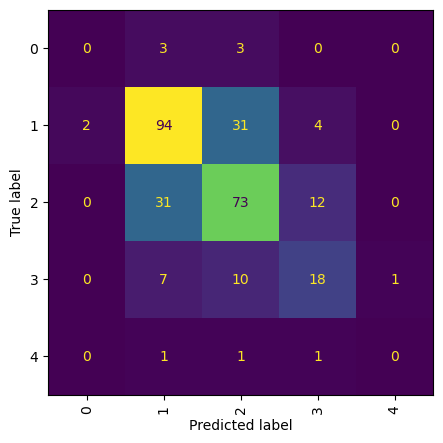

In [108]:
accuracy = evaluate(best_estimator_clf, X_train, y_train, X_test, y_test)

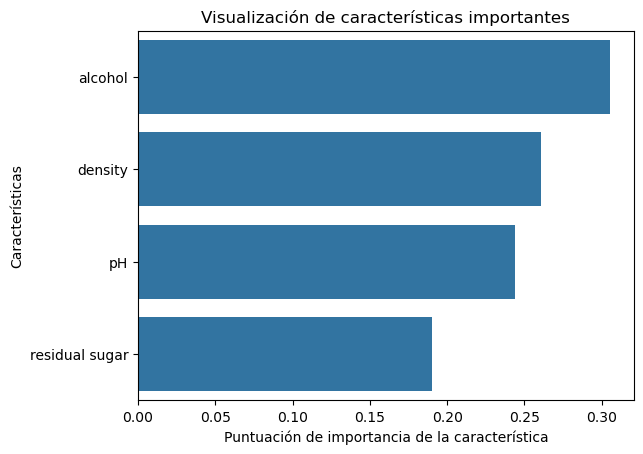

In [31]:
feature_imp = pd.Series(rf_random_clf.best_estimator_.feature_importances_, index = df.columns[:4]).sort_values(ascending = False)
feature_imp
# Visualización de características importantes
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Puntuación de importancia de la característica')
plt.ylabel('Características')
plt.title("Visualización de características importantes")
plt.show()

## Resultados Random Forest para Regresión

In [122]:
# Obtener el mejor estimador y sus parámetros
best_estimator_reg = rf_random_reg.best_estimator_
best_params_reg = rf_random_reg.best_params_
best_score_red = rf_random_reg.best_score_
# Imprimir los resultados
print("Mejor estimador RF Regresión encontrado:")
print(best_estimator_reg)
print("Mejores parámetros RF Regresión encontrados:")
print(best_params_reg)
print(f"El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: {best_score_red:.4}")

Mejor estimador RF Regresión encontrado:
RandomForestRegressor(max_depth=14, max_features='sqrt', min_samples_split=5,
                      n_estimators=600)
Mejores parámetros RF Regresión encontrados:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: 0.3201


In [205]:
# Realizar predicciones
y_pred = best_estimator_reg.predict(X_test)
print(y_pred[:10])

# Calcular MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calcular R^2
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2:.4f}")

[5.91622924 6.12790843 5.71403825 5.54735371 6.39781278 5.58391526
 5.66945695 4.96470617 5.22391222 6.08903334]
Mean Squared Error (MSE): 0.3960
Mean Absolute Error (MAE): 0.4711
R-squared (R²): 0.3120


No aplica el informe de clasificación porque este es un modelo de regresión, el cual entrega valores numéricos continuos en y_pred, no clases categóricas. Cuando intentas aplicar métricas de clasificación (como precisión, recall o F1-score) a los resultados de un modelo de regresión, el sistema no puede procesar los valores continuos porque esas métricas están diseñadas específicamente para evaluar predicciones categóricas.

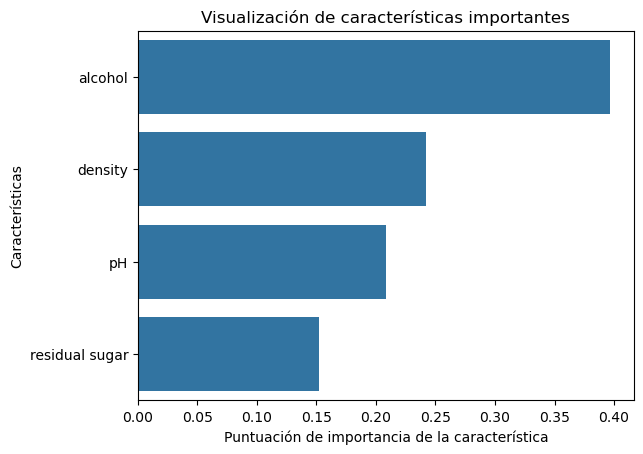

In [34]:
feature_imp = pd.Series(rf_random_reg.best_estimator_.feature_importances_, index = df.columns[:4]).sort_values(ascending = False)
feature_imp
# Visualización de características importantes
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Puntuación de importancia de la característica')
plt.ylabel('Características')
plt.title("Visualización de características importantes")
plt.show()

## Extra Trees Classifier (ETC)

In [35]:
# Utilice la cuadrícula aleatoria para buscar los mejores hiperparámetros
# Crear el modelo ExtraTreesClassifier
etc = ExtraTreesClassifier()
# Búsqueda aleatoria de parámetros, utilizando validación cruzada triple,
# Busque en 100 combinaciones diferentes y utilice todos los núcleos disponibles
rf_etc = RandomizedSearchCV(estimator = etc, param_distributions = random_grid, n_iter = 100, cv = 7, verbose = 2, random_state = 42, n_jobs = -1)
# Ajustar el modelo de búsqueda aleatoria
rf_etc.fit(X_train, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


RandomizedSearchCV(cv=7, estimator=ExtraTreesClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 30],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              100],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [36]:
# Obtener el mejor estimador y sus parámetros
best_estimator_etc = rf_etc.best_estimator_
best_params_etc = rf_etc.best_params_
best_score_etc = rf_etc.best_score_
# Imprimir los resultados
print("Mejor estimador para ETC encontrado:")
print(best_estimator_etc)
print("Mejores parámetros ETC encontrados:")
print(best_params_etc)
print(f"El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: {best_score_etc:.3%}")

Mejor estimador para ETC encontrado:
ExtraTreesClassifier(max_depth=14, n_estimators=2000)
Mejores parámetros ETC encontrados:
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': False}
El mejor puntaje promedio de validación cruzada: 64.58%


Primeras 10 predicciones: [6 6 6 6 6 5 6 5 5 6]
Precisión (Accuracy) = 65.753%.
Puntuación media de la validación cruzada: 64.0610%
Puntuación de Recall: 0.6575%
Puntuación de Precisión: 0.6377%
Puntuación F1: 0.6464%
Informe de Clasificación
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.72      0.77      0.74       131
           6       0.62      0.65      0.64       116
           7       0.55      0.44      0.49        36
           8       0.00      0.00      0.00         3

    accuracy                           0.66       292
   macro avg       0.38      0.37      0.37       292
weighted avg       0.64      0.66      0.65       292

Confusion Matrix


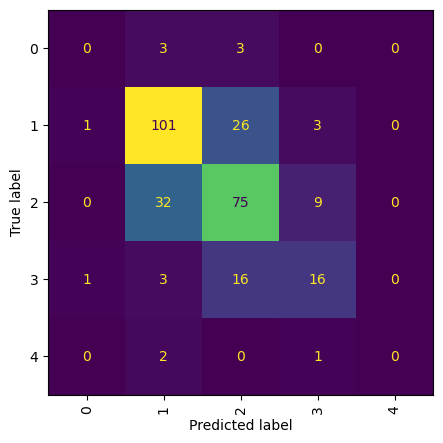

In [125]:
accuracy = evaluate(best_estimator_etc, X_train, y_train, X_test, y_test)

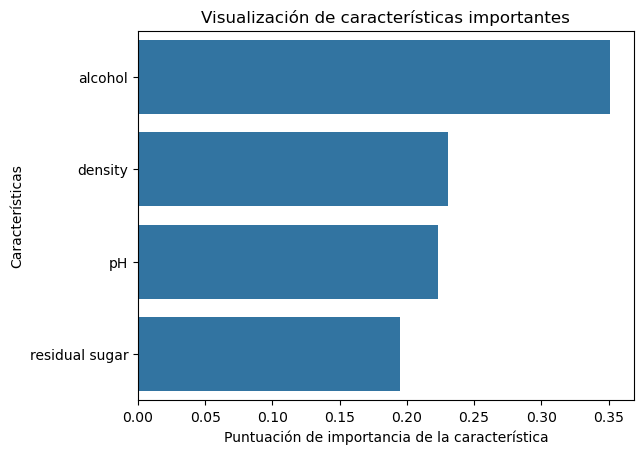

In [38]:
feature_imp = pd.Series(rf_etc.best_estimator_.feature_importances_, index = df.columns[:4]).sort_values(ascending = False)
feature_imp
# Visualización de características importantes
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Puntuación de importancia de la característica')
plt.ylabel('Características')
plt.title("Visualización de características importantes")
plt.show()

## Extra Trees Regressor 

In [39]:
from sklearn.ensemble import ExtraTreesRegressor
# y_train = np.argmax(y_train, axis=1)
# y_test = np.argmax(y_test, axis=1)
# Utilice la cuadrícula aleatoria para buscar los mejores hiperparámetros
# Primero crea el modelo base
etr_reg = ExtraTreesRegressor()
# Configurar RandomizedSearchCV
rf_etr_reg = RandomizedSearchCV(estimator = etr_reg, param_distributions = random_grid, n_iter = 100, cv = 7, verbose = 2, random_state = 42, n_jobs = -1)
# Ajustar el modelo de búsqueda aleatoria
rf_etr_reg.fit(X_train, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


RandomizedSearchCV(cv=7, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 30],
                                        'min_samples_split': [2, 5, 10, 50,
                                                              100],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [126]:
# Obtener el mejor estimador y sus parámetros
best_estimator_etr = rf_etr_reg.best_estimator_
best_params_etr = rf_etr_reg.best_params_
best_score_etr = rf_etr_reg.best_score_
# Imprimir los resultados
print("Mejor estimador ETR encontrado:")
print(best_estimator_etr)
print("Mejores parámetros ETR encontrados:")
print(best_params_etr)
print(f"El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: {best_score_clf:.4}")

Mejor estimador ETR encontrado:
ExtraTreesRegressor(max_depth=14, max_features='sqrt', n_estimators=2000)
Mejores parámetros ETR encontrados:
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': False}
El mejor puntaje promedio de validación cruzada encontrado por RandomizedSearchCV: 0.6501


In [41]:
# Realizar predicciones
y_pred = best_estimator_etr.predict(X_test)
print(y_pred[:10])

# Calcular MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calcular R^2
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

[5.7824093  6.07441586 5.65722171 5.4765755  6.37904791 5.43497455
 5.69452073 4.87517574 5.25734239 6.08543352]
Mean Squared Error (MSE): 0.38842975929897616
Mean Absolute Error (MAE): 0.4600302126810149
R-squared (R²): 0.3251334692436494


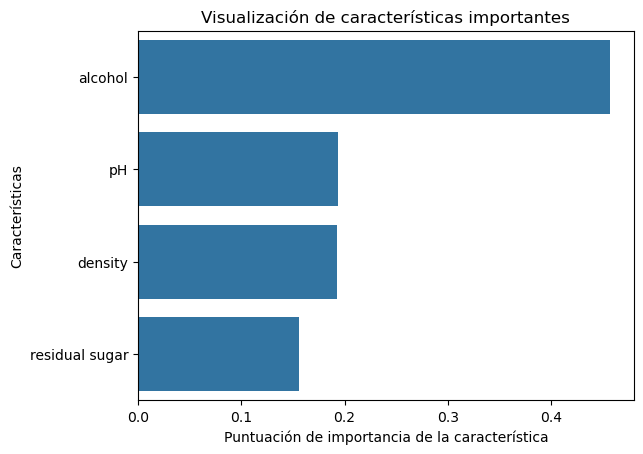

In [42]:
feature_imp = pd.Series(rf_etr_reg.best_estimator_.feature_importances_, index = df.columns[:4]).sort_values(ascending = False)
feature_imp
# Visualización de características importantes
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Puntuación de importancia de la característica')
plt.ylabel('Características')
plt.title("Visualización de características importantes")
plt.show()

## Redes Neuronales con Clasificación

In [35]:
# Codifica las etiquetas como matrices de "one-hot"
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [44]:
# Define your model-building function
def build_model(hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg):
    model = Sequential()
    # model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation, kernel_regularizer=l1(l1_reg) + l2(l2_reg)))
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    for _ in range(hidden_layers - 1):
        # model.add(Dense(neurons, activation=activation, kernel_regularizer=l1(l1_reg) + l2(l2_reg)))
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation,
                kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the grid of parameters to search
# param_grid = {
#     'hidden_layers': [1, 2, 3, 4, 5, 6],
#     'neurons': [8, 16, 32, 64, 128, 256, 512],
#     'activation': ['relu', 'tanh', 'sigmoid'],
#     'dropout_rate': [0.0, 0.1, 0.3],
#     'l1_reg': [0.0, 0.1, 0.01],
#     'l2_reg': [0.0, 0.1, 0.01]
# }
param_grid = {
    'hidden_layers': [3, 4, 5, 6],
    'neurons': [4, 8, 16, 32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout_rate': [0.0],
    'l1_reg': [0.0],
    'l2_reg': [0.0]
}

# Inicializa variables para almacenar los mejores resultados
best_score = 0
best_params = None
best_model_rnc = None

In [45]:
modelset, modeliter, best_iter = [], 0, 0

kf = KFold(n_splits=7, shuffle=True, random_state=42)  # Puedes ajustar el número de splits

for params in itertools.product(*param_grid.values()):
    # Unpack parameters
    hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg = params
    print(f"Iteration: {modeliter}")
    print(f"Parameters: {params}")

    fold_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Construir y entrenar el modelo
        model = build_model(hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg)
        model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=10, verbose=0)
        
        # Evaluar el modelo
        score = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]  # [1] es precisión
        fold_scores.append(score)
    
    avg_score = np.mean(fold_scores)
    print(f"Average Score (Accuracy): {avg_score}")

    # Actualizar el mejor puntaje
    if avg_score > best_score:
        best_score = avg_score
        best_iter = modeliter
        best_params = params
        best_model_rnc = model
        
    modeliter += 1

# Imprimir la mejor configuración
print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")
print(f"Best Iter: {best_iter}")

Iteration: 0
Parameters: (3, 4, 'relu', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5506353846618107
Iteration: 1
Parameters: (3, 4, 'tanh', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5574066979544503
Iteration: 2
Parameters: (3, 4, 'sigmoid', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.560910872050694
Iteration: 3
Parameters: (3, 8, 'relu', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5497696655137199
Iteration: 4
Parameters: (3, 8, 'tanh', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5625959719930377
Iteration: 5
Parameters: (3, 8, 'sigmoid', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5634153357573918
Iteration: 6
Parameters: (3, 16, 'relu', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5514702115740094
Iteration: 7
Parameters: (3, 16, 'tanh', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5574633819716317
Iteration: 8
Parameters: (3, 16, 'sigmoid', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.5660280159541539
Iteration: 9
Parameters: (3, 32, 'relu', 0.0, 0.0, 0.0)
Average Score (Accuracy): 0.56774

In [46]:
best_model_rnc

In [47]:
# Evaluar el mejor modelo en el conjunto de prueba
score = best_model_rnc.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 1.6568 - accuracy: 0.6199


In [129]:
print('Accuracy = {:0.3f}%.'.format(100 * score[1]))

Accuracy = 61.986%.


In [135]:
# Predict on the test set
y_pred = np.argmax(best_model_rnc.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
    
print(f"Accuracy: {accuracy * 100:.3f}%")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

10/10 [==============================] - 0s 3ms/step
Accuracy: 61.986%
Recall: 0.6199
Precision: 0.6110
F1 Score: 0.6147


In [137]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.71      0.74      0.72       131
           6       0.61      0.57      0.59       116
           7       0.43      0.50      0.46        36
           8       0.00      0.00      0.00         3

    accuracy                           0.62       292
   macro avg       0.35      0.36      0.35       292
weighted avg       0.61      0.62      0.61       292



Matriz de Confusión:


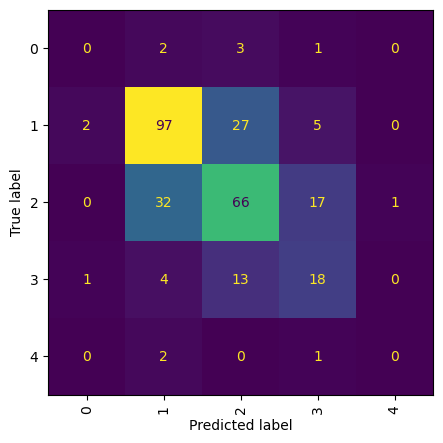

In [145]:
conf_matrix = confusion_matrix(y_true, y_pred)
print('Matriz de Confusión:')
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(5, 5))
disp = disp.plot(xticks_rotation='vertical', ax=ax, colorbar=False)
plt.show()

## Redes Neuronales con Regresión Lineal

In [64]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [66]:
# Función para construir el modelo
def build_regression_model(hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg):
    model = Sequential()
    # Primera capa con regularización
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation,
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    # Capas ocultas adicionales
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    # Capa de salida (lineal para regresión)
    model.add(Dense(1, activation='linear'))
    # Compilación del modelo
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

# Definimos los hiperparámetros a probar
param_grid = {
    'hidden_layers': [3, 4, 5, 6],
    'neurons': [4, 8, 16, 32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout_rate': [0.0],
    'l1_reg': [0.0],
    'l2_reg': [0.0]
}

# Número de particiones para validación cruzada
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inicializamos variables para almacenar los mejores resultados
best_score = float('inf')  # MSE es mejor cuanto más bajo
best_params = None

In [68]:
modelset, modeliter, best_iter = [], 0, 0

# Iteramos sobre todas las combinaciones de hiperparámetros
for params in itertools.product(*param_grid.values()):
    # Desempaquetamos los parámetros
    hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg = params
    print(f"Iteration: {modeliter}")
    print(f"Parameters: {params}")
    
    # Lista para almacenar los puntajes en cada fold
    fold_scores = []
    
    # Validación cruzada
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Construimos y entrenamos el modelo
        model = build_regression_model(hidden_layers, neurons, activation, dropout_rate, l1_reg, l2_reg)
        model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=10, verbose=0)
        
        # Evaluamos el modelo en el fold de validación
        val_score = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]  # [0] es MSE
        fold_scores.append(val_score)
    
    # Calculamos el puntaje promedio de MSE para todos los folds
    mean_fold_score = np.mean(fold_scores)
    print(f"Mean Score (MSE): {mean_fold_score}")
    
    # Actualizamos el mejor puntaje
    if mean_fold_score < best_score:  # Buscamos el MSE más bajo
        best_iter = modeliter
        best_score = mean_fold_score
        best_params = params
        best_model_rnr = model
    modeliter += 1

# Imprimimos la mejor configuración
print(f"Best Score (MSE): {best_score}")
print(f"Best Parameters: {best_params}")
print(f"Best Iter: {best_iter}")

Iteration: 0
Parameters: (3, 4, 'relu', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.48716058475630625
Iteration: 1
Parameters: (3, 4, 'tanh', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4444810024329594
Iteration: 2
Parameters: (3, 4, 'sigmoid', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.44862774440220426
Iteration: 3
Parameters: (3, 8, 'relu', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.44462444526808603
Iteration: 4
Parameters: (3, 8, 'tanh', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.44719823769160677
Iteration: 5
Parameters: (3, 8, 'sigmoid', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4429517090320587
Iteration: 6
Parameters: (3, 16, 'relu', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4795598430292947
Iteration: 7
Parameters: (3, 16, 'tanh', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4450799269335611
Iteration: 8
Parameters: (3, 16, 'sigmoid', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4423250215394156
Iteration: 9
Parameters: (3, 32, 'relu', 0.0, 0.0, 0.0)
Mean Score (MSE): 0.4693449693066733
Iteration: 10
Parameters: (3, 32, 'tanh', 0.0, 0.0, 0.0)
Mean S

In [75]:
best_model_rnr

In [77]:
# Evaluamos el mejor modelo en el conjunto de prueba
test_score = best_model_rnr.evaluate(X_test, y_test, verbose=0)[1]
print('MSE en la validación cruzada = {:0.4f}'.format(test_score))

MSE en la validación cruzada = 0.4082


In [79]:
# Ahora calcula el R^2
y_pred = best_model_rnr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Coeficiente de Determinación (R^2) = {:0.4f}'.format(r2))
# Calcular el MSE utilizando las predicciones
mse = mean_squared_error(y_test, y_pred, squared = False)
print('MSE = {:0.4f}'.format(mse))

10/10 [==============================] - 0s 2ms/step
Coeficiente de Determinación (R^2) = 0.2907
MSE = 0.6389


In [67]:
from joblib import dump
dump(best_estimator_etr, '../models/best_estimator_etr.joblib')

['../models/best_estimator_etr.joblib']

In [69]:
ferm_data = pd.read_excel('../data/BDD_MANUAL.xlsx')
# relevant_columns = ['Fecha', 'densidad', 'brix aprox', 'alcohol aprox', 'Ph', 'lote']
# ferm_data = ferm_data[relevant_columns]
ferm_data.rename(columns={'alcohol aprox': 'alcohol','brix aprox':'residual sugar', 'densidad': 'density', 'Ph':'pH'}, inplace=True)

In [71]:
ferm_data_scaled = Scaler_X.transform(ferm_data[['alcohol', 'residual sugar', 'density', 'pH']])
predictions = best_estimator_etr.predict(ferm_data_scaled)
ferm_data['prediction'] = predictions
ferm_data.head(10)

,Fecha,dias,Temp,Celcius,density,residual sugar,brix refrectometro,Alcolyzer,alcohol,pH,lugar,lote,lote1,Acidez Total,T ambiente,Observaciones,Tipo de uva,Unnamed: 17,prediction
0,2023-10-02,1,69.6,20.888889,1.09738,23.2,23.0,-0.08,0.00000,3.06,Laboratorio,1,L1CA,4.6,NaN,Inicio,Uva colombia,NaN,5.22525
1,2023-10-02,1,69.2,20.666667,1.10033,23.8,22.0,-0.13,0.00000,3.04,Laboratorio,2,L2SA,NaN,NaN,Inicio,Uva colombia,NaN,5.22775
2,2023-10-03,2,69.2,20.666667,1.09008,21.6,21.5,0.81,0.95630,3.06,Laboratorio,1,L1CA,NaN,NaN,NaN,Uva colombia,NaN,5.22525
3,2023-10-03,2,69.4,20.777778,1.09125,21.8,21.0,1.13,1.18948,3.04,Laboratorio,2,L2SA,NaN,NaN,NaN,Uva colombia,NaN,5.22775
4,2023-10-04,3,71.5,21.944444,1.08709,21.0,19.0,1.67,1.34799,3.06,Laboratorio,1,L1CA,NaN,20.3,NaN,Uva colombia,NaN,5.22525
5,2023-10-04,3,70.7,21.500000,1.08067,19.4,20.5,2.14,2.57546,3.04,Laboratorio,2,L2SA,NaN,20.3,NaN,Uva colombia,NaN,5.22775
6,2023-10-05,4,71.6,22.000000,1.08360,20.0,18.0,2.04,1.80518,3.06,Laboratorio,1,L1CA,NaN,NaN,NaN,Uva colombia,NaN,5.22525
7,2023-10-05,4,69.2,20.666667,1.06392,15.6,19.5,2.76,4.76971,3.04,Laboratorio,2,L2SA,NaN,NaN,NaN,Uva colombia,NaN,5.22775
8,2023-10-06,5,69.6,20.888889,1.07672,18.6,18.5,2.99,2.70646,3.06,Laboratorio,1,L1CA,NaN,20.5,NaN,Uva colombia,NaN,5.22525
9,2023-10-06,5,71.1,21.722222,1.04863,12.0,17.0,3.67,6.77270,3.06,Laboratorio,2,L2SA,NaN,20.5,NaN,Uva colombia,NaN,5.22525


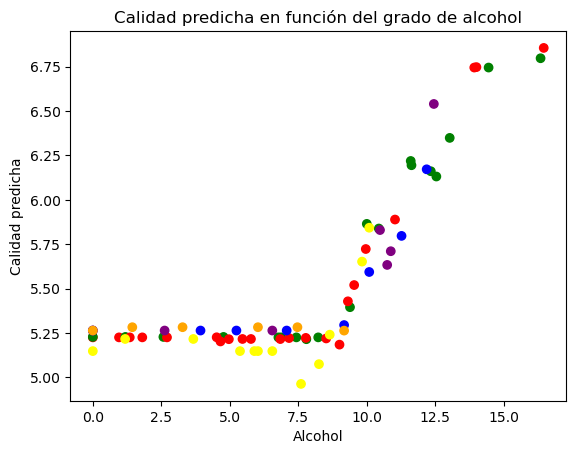

In [85]:
import matplotlib.pyplot as plt
colors = {'L1CA':'red', 'L2SA':'green', 'B3SA':'blue', 'B4SA':'purple', 'B5SA':'yellow', 'B6SA':'orange'}
plt.scatter(x=ferm_data['alcohol'], y=ferm_data['prediction'], c=ferm_data['lote1'].map(colors))
plt.title('Calidad predicha en función del grado de alcohol')
plt.xlabel("Alcohol")
plt.ylabel("Calidad predicha")
plt.savefig('../fig/alcohol.png')
plt.show()

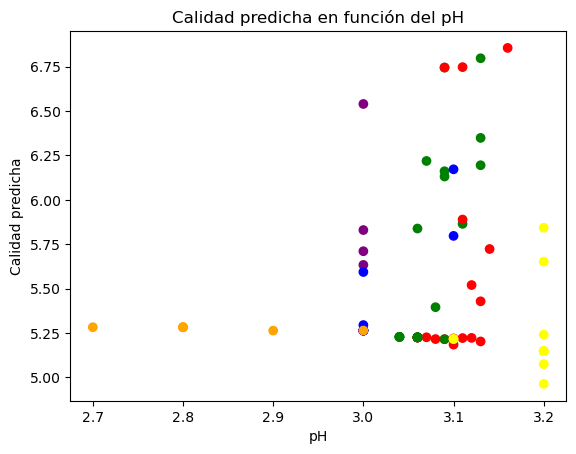

In [87]:
import matplotlib.pyplot as plt
colors = {'L1CA':'red', 'L2SA':'green', 'B3SA':'blue', 'B4SA':'purple', 'B5SA':'yellow', 'B6SA':'orange'}
plt.scatter(x=ferm_data['pH'], y=ferm_data['prediction'], c=ferm_data['lote1'].map(colors))
plt.title('Calidad predicha en función del pH')
plt.xlabel("pH")
plt.ylabel("Calidad predicha")
plt.savefig('../fig/ph.png')
plt.show()

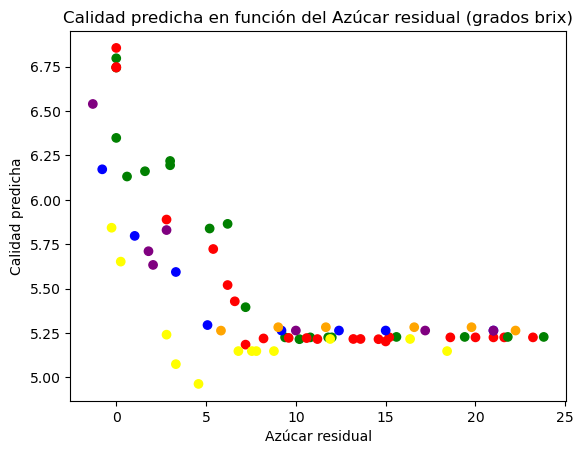

In [89]:
import matplotlib.pyplot as plt
colors = {'L1CA':'red', 'L2SA':'green', 'B3SA':'blue', 'B4SA':'purple', 'B5SA':'yellow', 'B6SA':'orange'}
plt.scatter(x=ferm_data['residual sugar'], y=ferm_data['prediction'], c=ferm_data['lote1'].map(colors))
plt.title('Calidad predicha en función del Azúcar residual (grados brix)')
plt.xlabel("Azúcar residual")
plt.ylabel("Calidad predicha")
plt.savefig('../fig/brix.png')
plt.show()

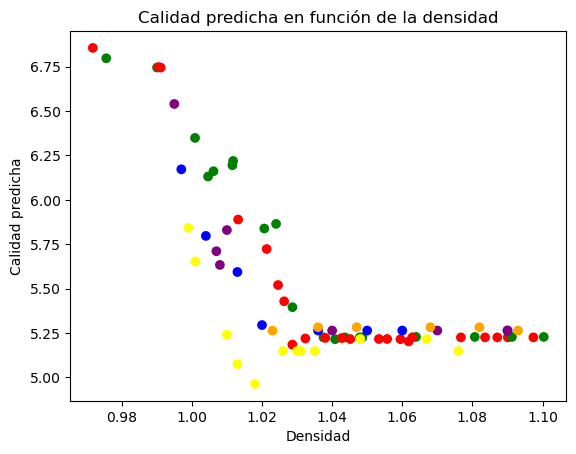

In [91]:

import matplotlib.pyplot as plt
colors = {'L1CA':'red', 'L2SA':'green', 'B3SA':'blue', 'B4SA':'purple', 'B5SA':'yellow', 'B6SA':'orange'}
plt.scatter(x=ferm_data['density'], y=ferm_data['prediction'], c=ferm_data['lote1'].map(colors))
plt.title('Calidad predicha en función de la densidad')
plt.xlabel("Densidad")
plt.ylabel("Calidad predicha")
plt.savefig('../fig/densidad.png')
plt.show()